In [1]:
from tensorflow import one_hot, argmax, enable_eager_execution
enable_eager_execution()
import sys
sys.path.append('../train/UNet')
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
from unetModelFunc import *
import importlib
import datetime

%matplotlib inline

In [2]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.

    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.

    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).

    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image, cmap=plt.cm.binary)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [3]:
data_path = '../../data'

print("Reading data")
f = h5py.File(os.path.join(data_path, 'train_16.h5'), 'r')
print("Read data")
X_train = np.array(f['train'])

images_list = [8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] # road images
y_train = np.array(f['train_mask'])[:, [0,2]]
y_train = np.expand_dims(y_train, 1)

X_train = X_train[images_list,:,:,:]
y_train = y_train[images_list,:,:,:]

import random
random.seed(a=1)
mylist = random.sample(range(11), 11)

print(X_train.shape)
X_train = X_train[mylist,:,:,:]
y_train = y_train[mylist,:,:,:]
print(y_train.shape)
f.close()

Reading data
Read data
(11, 16, 3345, 3338)
(11, 1, 2, 3345, 3338)


In [4]:
print("Reading model weights")
road_model = UNetModel(shape=(1600,1600,16), origDepth=32)
build_model = UNetModel(shape=(1600,1600,16), origDepth=32)
build_model.load_weights("../cache/model_weights_128_49_buildings_3_split.h5")
road_model.load_weights(os.path.join('../cache/UNet', 'model_weights_128_21_roads_3_2020-07-09 14:04_continued.h5'))
print("Read model weights")

Reading model weights
Read model weights


(16, 3345, 3338)
<class 'numpy.float16'>
2020-09-27 23:23:13.534392
(16, 1600, 1600)
2020-09-27 23:23:16.480655


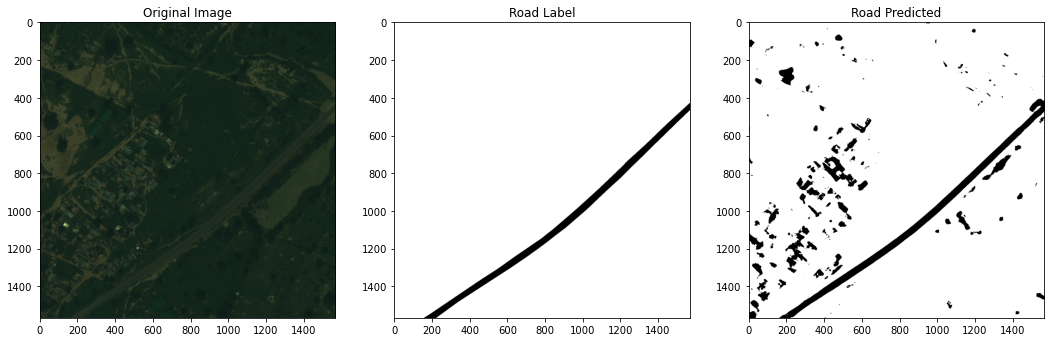

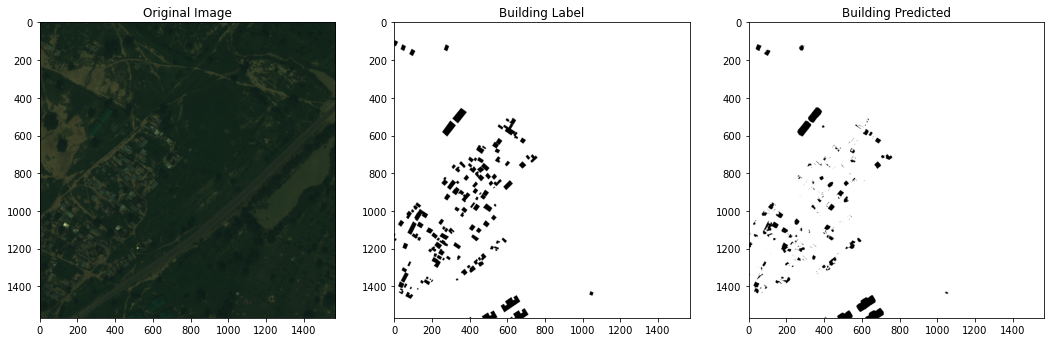

In [13]:
img = 0
startWidth = 1400
endWidth = startWidth + 1600
startHeight = 1000
endHeight = startHeight + 1600

X_train_img = X_train[img]
y_train_img = y_train[img]

print(X_train_img.shape)
print(type(X_train_img[1,1,1]))


#a = X_train.swapaxes(0,2)[1600:1696,100:196,:]
print(datetime.datetime.now())
moi = X_train_img[:,startHeight:endHeight, startWidth:endWidth]
print(moi.shape)

road_pred = np.squeeze(road_model.predict(np.expand_dims(moi.swapaxes(0,2), axis=0)))
build_pred = np.squeeze(build_model.predict(np.expand_dims(moi.swapaxes(0,2), axis=0)))
final_pred = one_hot(argmax(np.stack([np.zeros(build_pred.shape), build_pred*.99, road_pred]),axis=0),depth=3).numpy()

print(datetime.datetime.now())
show_images([X_train_img[13:,:,:].swapaxes(0,2).astype(np.float64)[startWidth+16:endWidth-16,startHeight+16:endHeight-16,:],
             1-y_train_img.astype(np.float64)[0,1,:].swapaxes(0,1)[startWidth+16:endWidth-16,startHeight+16:endHeight-16],
             final_pred[:,:,2]],
            titles=["Original Image", "Road Label", "Road Predicted"])
show_images([X_train_img[13:,:,:].swapaxes(0,2).astype(np.float64)[startWidth+16:endWidth-16,startHeight+16:endHeight-16,:],
             1-y_train_img.astype(np.float64)[0,0,:].swapaxes(0,1)[startWidth+16:endWidth-16,startHeight+16:endHeight-16],
             final_pred[:,:,1]],
            titles=["Original Image", "Building Label", "Building Predicted"])

In [14]:
print(final_pred.shape)
np.save('prediction.npy', final_pred)

(1568, 1568, 3)


In [30]:
!python contours.py

Total road segments found: 339
Road segments at a safe distance from buildings: 325
Best segment length:  1730.4129564933337 Angle:  51 degrees


In [31]:
best_segment = np.load('best_segment.npy', allow_pickle=True)

(1568, 1568, 3)
92980.92


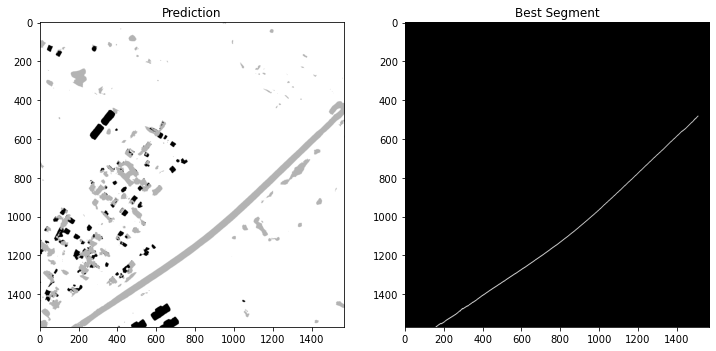

In [32]:
final_pred_ = final_pred.copy()
print(final_pred_.shape)
final_pred_[:,:,0]=0
final_pred_[:,:,2]=final_pred_[:,:,2]*0.3
final_pred_=np.sum(final_pred_,axis=2)
print(np.sum(final_pred_))
show_images([1-final_pred_, 1-best_segment], titles=["Prediction", "Best Segment"])

In [33]:
all_segments = np.load('all_segments.npy', allow_pickle=True)

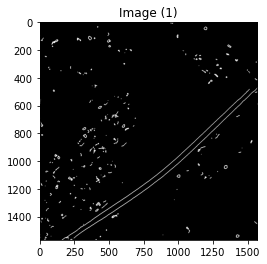

(1568, 1568)

In [34]:
show_images([all_segments])
best_segment.shape